<a href="https://colab.research.google.com/github/SeunghyeChae/Pneumonia-Detection_tmdhey/blob/main/Classification_InceptionV3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# https://www.kaggle.com/kamalkhumar/multiclass-classification-with-image-augmentation
# https://github.com/Venka97/Skin-cancer-image-classification/blob/master/Derma.ipynb

# Multiclass Classification (CNN Model)

In [2]:
import numpy as np 
import pandas as pd
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_dir = os.path.join("/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/")
print("Base directory --> ", os.listdir(base_dir),"\n")


# Train set
train_dir = os.path.join("/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/train/")
print("Train --> ", os.listdir(train_dir))

# Test set
test_dir = os.path.join("/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/test/")
print("Test --> ", os.listdir(test_dir))

# Validation set
validation_dir = os.path.join("/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/validation/")
print("Validation --> ", os.listdir(validation_dir)[:5])


Base directory -->  ['test', 'train', 'validation', 'Rock-Paper-Scissors', 'transfer_learning.hdf5', 'fine_tuning.hdf5.hdf5'] 

Train -->  ['paper', 'rock', 'scissors']
Test -->  ['paper', 'rock', 'scissors']
Validation -->  ['paper-hires1.png', 'paper-hires2.png', 'paper1.png', 'paper2.png', 'paper3.png']


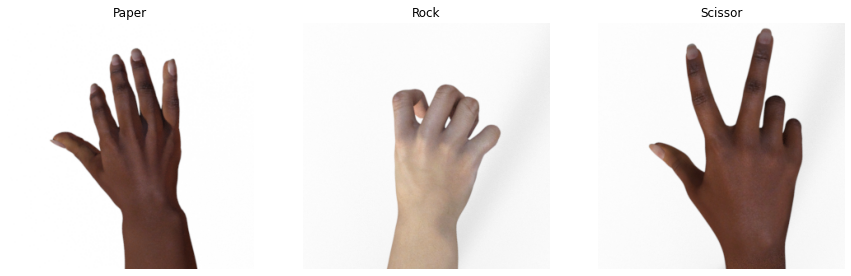

In [4]:
# Displaying random image from the dataset

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

sample_paper = random.choice(os.listdir(train_dir + "paper"))
image = load_img(train_dir + "paper/" + sample_paper)
ax[0].imshow(image)
ax[0].set_title("Paper")
ax[0].axis("Off")

sample_rock = random.choice(os.listdir(train_dir + "rock"))
image = load_img(train_dir + "rock/" + sample_rock)
ax[1].imshow(image)
ax[1].set_title("Rock")
ax[1].axis("Off")

sample_scissor = random.choice(os.listdir(train_dir + "scissors"))
image = load_img(train_dir + "scissors/" + sample_scissor)
ax[2].imshow(image)
ax[2].set_title("Scissor")
ax[2].axis("Off")

plt.show()

# model

In [5]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.preprocessing import image
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Input
# from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.models import Sequential,Model
from keras import backend as K
from IPython.display import display

In [6]:
# load pretrained model 
base_model  = InceptionV3(weights = 'imagenet', include_top=False)
print('loaded model')

87924736/87910968 [==============================] - 1s 0us/step
loaded model


In [7]:
data_gen_args = dict(preprocessing_function=preprocess_input, #Define the dictionary for Image data Generator
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

train_datagen = image.ImageDataGenerator(**data_gen_args)
test_datagen = image.ImageDataGenerator(**data_gen_args)

In [8]:

from keras.layers import Conv2D,MaxPooling2D,Flatten

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=2,padding='same'))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2,padding='same'))
model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2,padding='same'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 150, 150, 16)      208       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 75, 75, 32)        2080      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 38, 38, 64)        8256      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 19, 64)       0

In [9]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2, # Shifting image width by 20%
      height_shift_range=0.2,# Shifting image height by 20%
      shear_range=0.2,       # Rotation across X-axis by 20%
      zoom_range=0.2,        # Image zooming by 20%
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 20
)

Found 2520 images belonging to 3 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 20
)

Found 372 images belonging to 3 classes.


In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Save the model with best weights
checkpointer = ModelCheckpoint('/content/drive/MyDrive/cakd_colab/3차플젝/Skin-cancer-image-classification-master/model.hdf5', verbose=1,save_best_only=True)
# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=0,verbose=1,mode='auto')

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch = 50,validation_data=validation_generator,validation_steps=3, epochs=50,verbose=1,callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 1.3535 - accuracy: 0.3530
Epoch 00001: val_loss improved from inf to 1.08293, saving model to /content/drive/MyDrive/cakd_colab/3차플젝/Skin-cancer-image-classification-master/model.hdf5
50/50 [==============================] - 336s 7s/step - loss: 1.3535 - accuracy: 0.3530 - val_loss: 1.0829 - val_accuracy: 0.3667
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 1.0330 - accuracy: 0.4640
Epoch 00002: val_loss improved from 1.08293 to 0.85825, saving model to /content/drive/MyDrive/cakd_colab/3차플젝/Skin-cancer-image-classification-master/model.hdf5
50/50 [==============================] - 204s 4s/step - loss: 1.0330 - accuracy: 0.4640 - val_loss: 0.8583 - val_accuracy: 0.7833
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.5410
Epoch 00003: val_loss improved from 0.85825 to 0.73398, saving model to /content/drive/MyDrive/cakd_colab/3차플젝/Skin-cancer-

In [64]:
last = base_model.output
x = GlobalAveragePooling2D()(last)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(3,activation='softmax')(x)

# model = Model(input=base_model.input,output=preds)
model = Model(base_model.input,preds)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                         

In [65]:
#Load the weights for the common layers from the benchmark model
base_model.load_weights(filepath='/content/drive/MyDrive/cakd_colab/3차플젝/Skin-cancer-image-classification-master/model.hdf5',by_name=True)

In [66]:
#Freeze the original layers of Inception3
for layer in base_model.layers:
    layer.trainable = False

In [67]:
#Compile the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

In [68]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Save the model with best weights
checkpointer = ModelCheckpoint('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/transfer_learning.hdf5', verbose=1,save_best_only=True)
# Stop the traning if the model shows no improvement
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=1,verbose=1,mode='auto')

In [69]:
# Train the model
history_transfer = model.fit_generator(train_generator, steps_per_epoch = 13,validation_data=validation_generator,validation_steps=4, epochs=10,verbose=1,callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.8702 - accuracy: 0.6923
Epoch 00001: val_loss improved from inf to 0.65642, saving model to /content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/transfer_learning.hdf5
13/13 [==============================] - 11s 521ms/step - loss: 0.8702 - accuracy: 0.6923 - val_loss: 0.6564 - val_accuracy: 0.7500
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8769
Epoch 00002: val_loss did not improve from 0.65642
13/13 [==============================] - 3s 236ms/step - loss: 0.3508 - accuracy: 0.8769 - val_loss: 0.7716 - val_accuracy: 0.6875
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.8885
Epoch 00003: val_loss improved from 0.65642 to 0.33845, saving model to /content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/transfer_learning.hdf5
13/13 [==============================] - 4s 322ms/step - loss: 0.3118 - accuracy: 0.8885 -

In [70]:
# display(history_transfer.history)

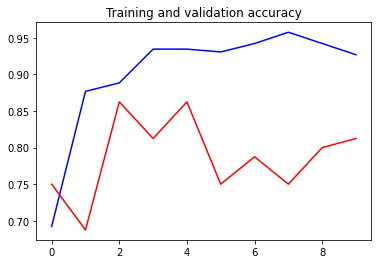

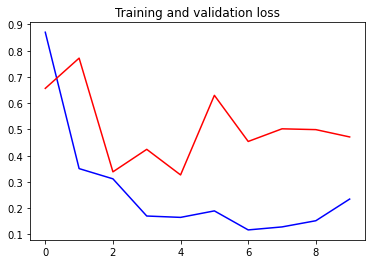

In [71]:
plot_training(history_transfer)

In [72]:
# fine tuning 
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [73]:
# Unfreeze the last three inception modules
for layer in model.layers[:229]:
    layer.trainable = False
for layer in model.layers[229:]:
    layer.trainable = True

In [74]:
from tensorflow.keras.optimizers import SGD

# Use an optimizer with slow learning rate
model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [75]:
#Save the model with best validation loss
checkpointer = ModelCheckpoint('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/fine_tuning.hdf5.hdf5', verbose=1,save_best_only=True,monitor='val_loss')

# Stop the traning if the validation loss doesn't improve
stopper = EarlyStopping(monitor='val_loss,val_acc',min_delta=0.1,patience=2,verbose=1,mode='auto')

In [ ]:
# Train the model
history = model.fit_generator(train_generator, steps_per_epoch = 13,validation_data=validation_generator,validation_steps=3, epochs=10,verbose=1,callbacks=[checkpointer])


# 모르고 5한번 10한번 돌림 ㅠ 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.9308
Epoch 00001: val_loss improved from inf to 0.30672, saving model to /content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/fine_tuning.hdf5.hdf5
13/13 [==============================] - 11s 485ms/step - loss: 0.2339 - accuracy: 0.9308 - val_loss: 0.3067 - val_accuracy: 0.8667
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8962
Epoch 00002: val_loss did not improve from 0.30672
13/13 [==============================] - 3s 228ms/step - loss: 0.2846 - accuracy: 0.8962 - val_loss: 0.3350 - val_accuracy: 0.8667
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9269
Epoch 00003: val_loss did not improve from 0.30672
13/13 [==============================] - 3s 227ms/step - loss: 0.2265 - accuracy: 0.9269 - val_loss: 0.5087 - val_accuracy: 0.8167
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 

In [ ]:
# Load the weights fromt the fine-tuned model
model.load_weights('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/fine_tuning.hdf5.hdf5')

In [ ]:
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def pred(img_path):    
    img = load_img(img_path,target_size = (150,150)) #Load the image and set the target size to the size of input of our model
    x = img_to_array(img) #Convert the image to array
    x = np.expand_dims(x,axis=0) #Convert the array to the form (1,x,y,z) 
    x = preprocess_input(x) # Use the preprocess input function o subtract the mean of all the images
    p = np.argmax(model.predict(x)) # Store the argmax of the predictions
    if p==0:     # P=0 for basal,P=1 for melanoma , P=2 for squamous
        print("paper")
    elif p==1:
        print("rock")
    elif p==2:
        print("scissors")

In [ ]:
pred('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/test/paper/testpaper01-00.png')

In [ ]:
pred('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/test/rock/testrock01-00.png')

In [ ]:
pred('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/test/scissors/testscissors01-00.png')

In [ ]:
pred('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/test/scissors/testscissors01-02.png')

In [ ]:
pred('/content/drive/MyDrive/cakd_colab/3차플젝/Rock-Paper-Scissors/test/scissors/testscissors01-19.png')

In [ ]:
#tq 

# plot_graph

In [34]:
def plot_training(history):
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs  = range(len(acc))
    
    plt.plot(epochs,acc,'b')
    plt.plot(epochs,val_acc,'r')
    plt.title("Training and validation accuracy")
    
    plt.figure()
    plt.plot(epochs,loss,'b')
    plt.plot(epochs,val_loss,'r')
    plt.title("Training and validation loss")
    
    plt.show()

# -------------------------------------------------------